<a href="https://colab.research.google.com/github/stevejj4/Data-Cleaning/blob/main/Insurance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install google-cloud-bigquery pandas


In [2]:
#Authenticating and Initializing BigQuery Client:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

project_id = 'river-messenger-430112-e1'

# Initializing BigQuery client
client = bigquery.Client(project=project_id)


In [3]:
# Loading data from google sheets to pandas DataFrames
import gspread
from google.auth import default

# Authenticating and creating the gspread client
creds, _ = default()
gc = gspread.authorize(creds)

# Openning the Google Sheets by title
worksheet_customers = gc.open('Insurance_data').worksheet('Customers')
worksheet_policies = gc.open('Insurance_data').worksheet('Policies')
worksheet_interactions = gc.open('Insurance_data').worksheet('Interactions')
worksheet_claims = gc.open('Insurance_data').worksheet('Claims')

# Loading the data into pandas DataFrames
customers_df = pd.DataFrame(worksheet_customers.get_all_records())
policies_df = pd.DataFrame(worksheet_policies.get_all_records())
interactions_df = pd.DataFrame(worksheet_interactions.get_all_records())
claims_df = pd.DataFrame(worksheet_claims.get_all_records())


In [4]:
# Uploading dataframes to Bigquery
def upload_to_bigquery(df, table_name):
    dataset_id = 'Insurance_data'
    # Using the `TableReference` class to construct the table ID in the correct format
    table_ref = bigquery.TableReference(
        bigquery.DatasetReference(project_id, dataset_id), table_name
    )

    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
    )

    job = client.load_table_from_dataframe(
        df, table_ref, job_config=job_config
    )

    job.result()  # Waiting for the job to complete

    print(f"Loaded {job.output_rows} rows into {table_ref}.")

# Uploading each DataFrame to BigQuery
upload_to_bigquery(customers_df, 'customers')
upload_to_bigquery(policies_df, 'policies')
upload_to_bigquery(interactions_df, 'interactions')
upload_to_bigquery(claims_df, 'claims')

Loaded 2004 rows into river-messenger-430112-e1.Insurance_data.customers.
Loaded 2004 rows into river-messenger-430112-e1.Insurance_data.policies.
Loaded 5000 rows into river-messenger-430112-e1.Insurance_data.interactions.
Loaded 3000 rows into river-messenger-430112-e1.Insurance_data.claims.


In [5]:
!pip install pyspark==3.1.2
!pip install google-cloud-bigquery
!pip install pandas-gbq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 11.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880745 sha256=4234e311841bdd6760ab1117d1e7acbaa87e2625a92552bcf4361d0b6ece96e5
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [6]:
# Reading data from bigquery into spark dataframes

from pyspark.sql import SparkSession

# Initializing a SparkSession with BigQuery connector
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
    .getOrCreate()

# Setting Google Cloud project ID and dataset ID
# These values are correct and match the ones in BigQuery project.
project_id = 'river-messenger-430112-e1'
dataset_id = 'Insurance_data'

# Defining table names
# Check that these table names exist in BigQuery dataset.
customers_table = f"{project_id}.{dataset_id}.customers"
policies_table = f"{project_id}.{dataset_id}.policies"

interactions_table = f"{project_id}.{dataset_id}.interactions"
claims_table = f"{project_id}.{dataset_id}.claims"

# Reading data from BigQuery into Spark DataFrames
df_customers = spark.read.format('bigquery').option('table', customers_table).load()
df_policies = spark.read.format('bigquery').option('table', policies_table).load()
df_interactions = spark.read.format('bigquery').option('table', interactions_table).load()
df_claims = spark.read.format('bigquery').option('table', claims_table).load()

# Printing the schema of each DataFrame to check if the data was loaded correctly
print("Schema of df_customers:")
df_customers.printSchema()

print("\nSchema of df_policies:")
df_policies.printSchema()

print("\nSchema of df_interactions:")
df_interactions.printSchema()

print("\nSchema of df_claims:")
df_claims.printSchema()

Schema of df_customers:
root
 |-- CustomerID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Region: string (nullable = true)


Schema of df_policies:
root
 |-- PolicyID: long (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- PolicyType: string (nullable = true)
 |-- PolicyStartDate: string (nullable = true)
 |-- PolicyEndDate: string (nullable = true)
 |-- PremiumAmount: double (nullable = true)


Schema of df_interactions:
root
 |-- InteractionID: long (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- InteractionDate: string (nullable = true)
 |-- InteractionType: string (nullable = true)
 |-- InteractionOutcome: string (nullable = true)


Schema of df_claims:
root
 |-- ClaimID: long (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- ClaimDate: string (nullable = true)
 |-- ClaimAmount: double (nullable = true)
 |-- ClaimStatus: string (nullable = true)



In [7]:
# Running SQL queries in BigQuery to jiun and fetch data
query = """
SELECT c.CustomerID, c.Age, p.PolicyType, cl.ClaimAmount, cl.ClaimStatus
FROM `river-messenger-430112-e1.Insurance_data.customers` c
JOIN `river-messenger-430112-e1.Insurance_data.policies` p ON c.CustomerID = p.CustomerID
JOIN `river-messenger-430112-e1.Insurance_data.claims` cl ON c.CustomerID = cl.CustomerID;
"""

df = client.query(query).to_dataframe()

# Display the first few rows
df.head()


,CustomerID,Age,PolicyType,ClaimAmount,ClaimStatus
0,43,18,Life,536.10,Pending
1,373,18,Life,19014.72,Approved
2,373,18,Life,3056.66,Rejected
3,411,18,Health,1820.65,Approved
4,420,18,Life,12201.43,Rejected


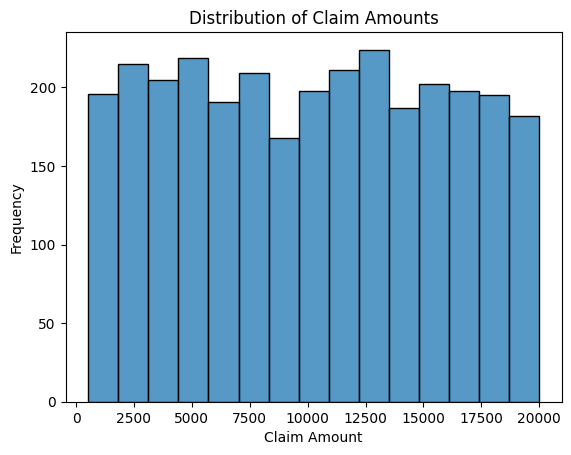

In [8]:
# Data visualization to understand the data distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Claim Amounts
sns.histplot(df['ClaimAmount'])
plt.title('Distribution of Claim Amounts')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.show()


In [9]:
#Data preprocessing and Machine learning
#Encoding categorical features and standardizing numerical features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Checking the available columns in your DataFrame
print(df.columns)

# Adjusting the column names based on the output of df.columns
X = df[['Age', 'PolicyType']]
y = df['ClaimAmount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps for numerical and categorical features
# Creating a pipeline to handle the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age']), # Standardizing numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['PolicyType']) # One-hot encode categorical features
    ])

# Creating a pipeline that includes preprocessing and model fitting
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())])

# Fitting the pipeline (including preprocessing and model training)
pipeline.fit(X_train, y_train)

# Predicting and evaluating
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Index(['CustomerID', 'Age', 'PolicyType', 'ClaimAmount', 'ClaimStatus'], dtype='object')
Mean Squared Error: 31077183.753261


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofmonth, month, year, count, when

spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
    .getOrCreate()

# BigQuery table configurations
project_id = 'river-messenger-430112-e1'
dataset_id = 'Insurance_data'
interactions_table = f"{project_id}.{dataset_id}.interactions"

# Load data into Spark DataFrame
df_interactions = spark.read.format('bigquery').option('table', interactions_table).load()

# Show schema
df_interactions.printSchema()


root
 |-- InteractionID: long (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- InteractionDate: string (nullable = true)
 |-- InteractionType: string (nullable = true)
 |-- InteractionOutcome: string (nullable = true)



In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofmonth, month, year, count, when

# Create Spark session
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
    .config('viewsEnabled', 'true') \
    .config('materializationDataset', 'YOUR_MATERIALIZATION_DATASET') \
    .getOrCreate()

# BigQuery table configurations
project_id = 'river-messenger-430112-e1'
dataset_id = 'Insurance_data'
table_id = 'interactions'
table_path = f"{project_id}.{dataset_id}.{table_id}"

try:
    # Load data into Spark DataFrame
    df_interactions = spark.read.format('bigquery') \
        .option('table', table_path) \
        .load()

    # Show schema
    df_interactions.printSchema()

    # Feature engineering
    df_interactions = df_interactions.withColumn("day_of_month", dayofmonth(col("InteractionDate"))) \
                                     .withColumn("month", month(col("InteractionDate"))) \
                                     .withColumn("year", year(col("InteractionDate")))

    # Number of interactions per day
    daily_interactions = df_interactions.groupBy("InteractionDate").agg(
        count("InteractionID").alias("total_interactions"),
        count(when(col("InteractionOutcome") == "resolved", True)).alias("resolved_interactions"),
        count(when(col("InteractionOutcome") == "not resolved", True)).alias("unresolved_interactions")
    )

    # Most satisfied interaction type
    satisfied_interactions = df_interactions.groupBy("InteractionType").agg(
        count("InteractionID").alias("total_interactions"),
        count(when(col("InteractionOutcome") == "resolved", True)).alias("resolved_interactions")
    ).orderBy("resolved_interactions", ascending=False)

    # Customers who called twice
    frequent_callers = df_interactions.groupBy("CustomerID").count().filter(col("count") > 1)

    # Show the results
    daily_interactions.show()
    satisfied_interactions.show()
    frequent_callers.show()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    spark.stop()


root
 |-- InteractionID: long (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- InteractionDate: string (nullable = true)
 |-- InteractionType: string (nullable = true)
 |-- InteractionOutcome: string (nullable = true)

An error occurred: An error occurred while calling o183.showString.
: com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.InvalidArgumentException: com.google.cloud.spark.bigquery.repackaged.io.grpc.StatusRuntimeException: INVALID_ARGUMENT: Invalid resource field value in the request.
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.ApiExceptionFactory.createException(ApiExceptionFactory.java:47)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.grpc.GrpcApiExceptionFactory.create(GrpcApiExceptionFactory.java:72)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.grpc.GrpcApiExceptionFactory.create(GrpcApiExceptionFactory.java:60)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.